# <font color='orangered'>Previsão de preços na bolsa de valores com SARIMAX</font>

## 1- Pacotes

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import ta
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure
from matplotlib import cycler
import matplotlib.dates as mdates
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('seaborn')

import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

C:\Users\mfran\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\mfran\AppData\Local\Temp\ipykernel_2200\2735663968.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 2- Coleta dos dados

In [2]:
# Cria função para extrair os dados das ações direto do Yahoo! Finance

def extrai_dados(ticker):
    
    # Busca 5 anos de dados a partir de 01/09/2019
    dados = yf.download(ticker, start = "2019-09-01")
    
    # Colunas do dataframe
    dados.columns = ["open", "high", "low", "close", "adj close", "volume"]
    
    # Data como índice
    dados.index.name = "date"
    
    return dados

In [3]:
df = extrai_dados("AMZN")
df.tail()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2024-11-01,199.000000,200.500000,197.020004,197.929993,197.929993,99687800
2024-11-04,196.449997,197.330002,194.309998,195.779999,195.779999,38492100
2024-11-05,196.039993,199.820007,195.990005,199.500000,199.500000,30564800
2024-11-06,200.009995,207.550003,199.139999,207.089996,207.089996,72292200
2024-11-07,207.440002,212.250000,207.190002,210.050003,210.050003,52820000


## 3- Engenharia de atributos

In [4]:
# Função para engenharia de atributos
def func_engenharia_atributos(df):

    # Cópia do dataframe
    df_copy = df.copy()

    # Cria a variável com o retorno (mudança percentual do fechamento - close)
    # Essa será nossa variável alvo
    df_copy["retorno"] = df_copy["close"].pct_change(1)

    # Shift das colunas de preço do ativo financeiro
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    # Shift da coluna Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    # Simple Moving Average (SMA)
    df_copy["SMA 25"] = df_copy[["close"]].rolling(25).mean().shift(1)
    df_copy["SMA 300"] = df_copy[["close"]].rolling(300).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    df_copy["MSD 25"] = df_copy["retorno"].rolling(25).std().shift(1)
    df_copy["MSD 300"] = df_copy["retorno"].rolling(300).std().shift(1)

    # Volume Weighted Average Price (VWAP)
    vwap = ta.volume.VolumeWeightedAveragePrice(high = df['high'],
                                                low = df['low'],
                                                close = df['close'],
                                                volume = df['volume'],
                                                window = 5)
    
    df_copy["VWAP"] = vwap.vwap.shift(1)

    # Relative Strength Index (RSI)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    
    df_copy["RSI"] = RSI.rsi().shift(1)

    return df_copy.dropna()

In [5]:
# Engenharia de atributos
df = func_engenharia_atributos(df)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [6]:
df.shape

(1005, 18)

## 4- Decomposição da série temporal

In [7]:
resultado = seasonal_decompose(df['close'], model = 'multiplicative', period = 365)

([], [])

<Figure size 800x550 with 0 Axes>

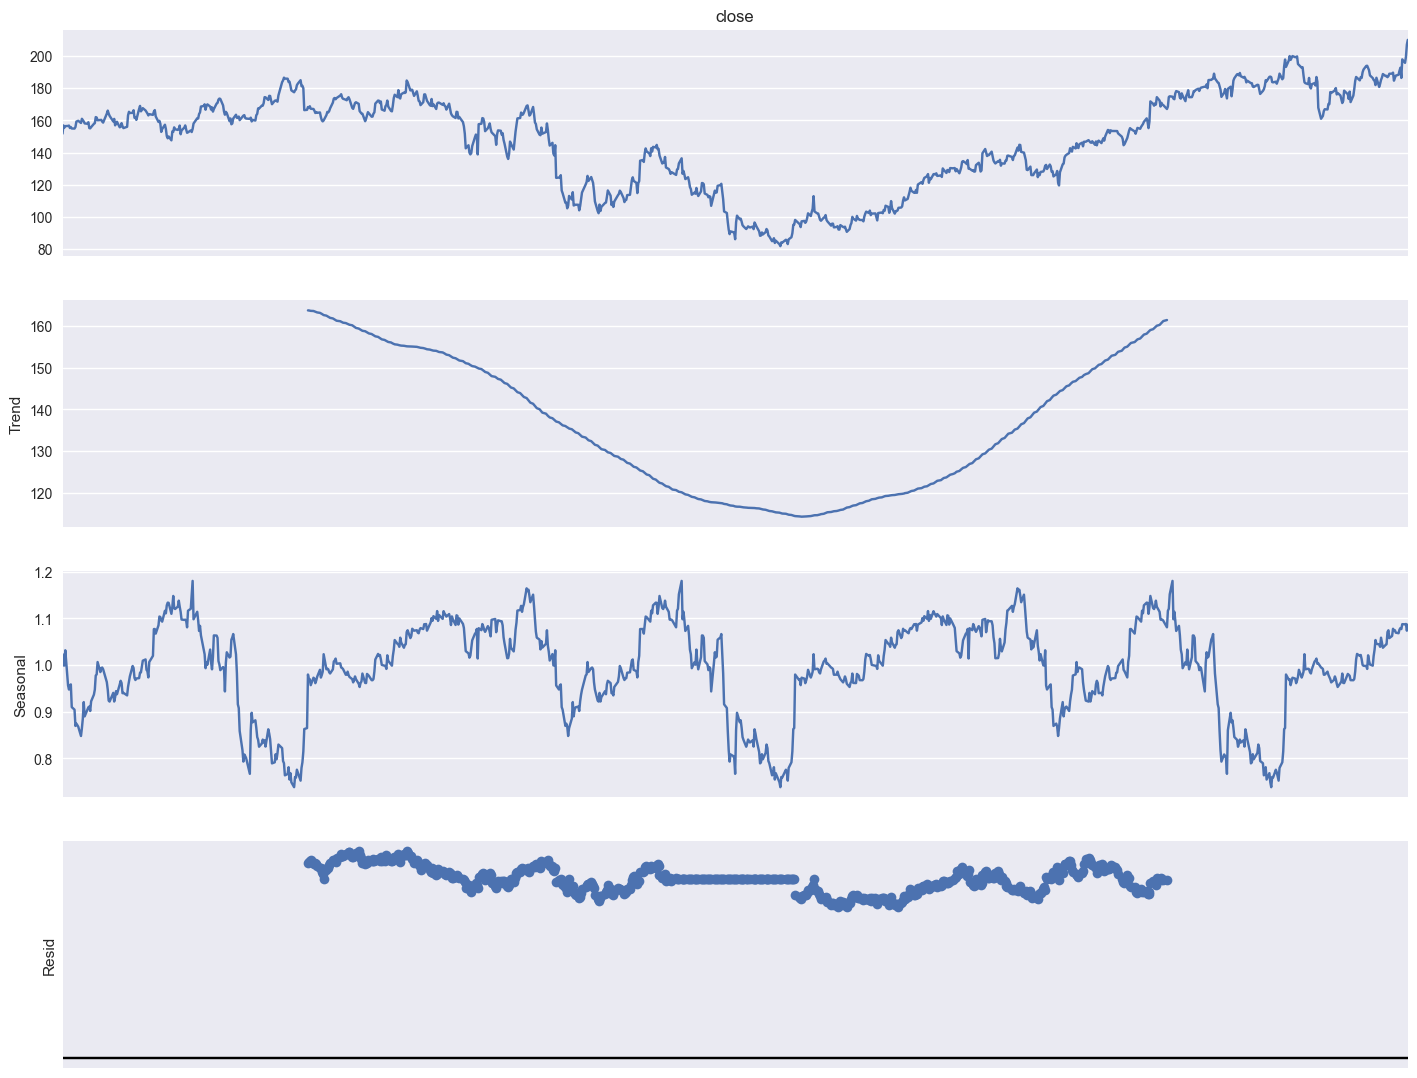

In [8]:
# Plot
fig = plt.figure()  
fig = resultado.plot()  
fig.set_size_inches(15, 12)
plt.xticks([]) 
plt.yticks([]) 

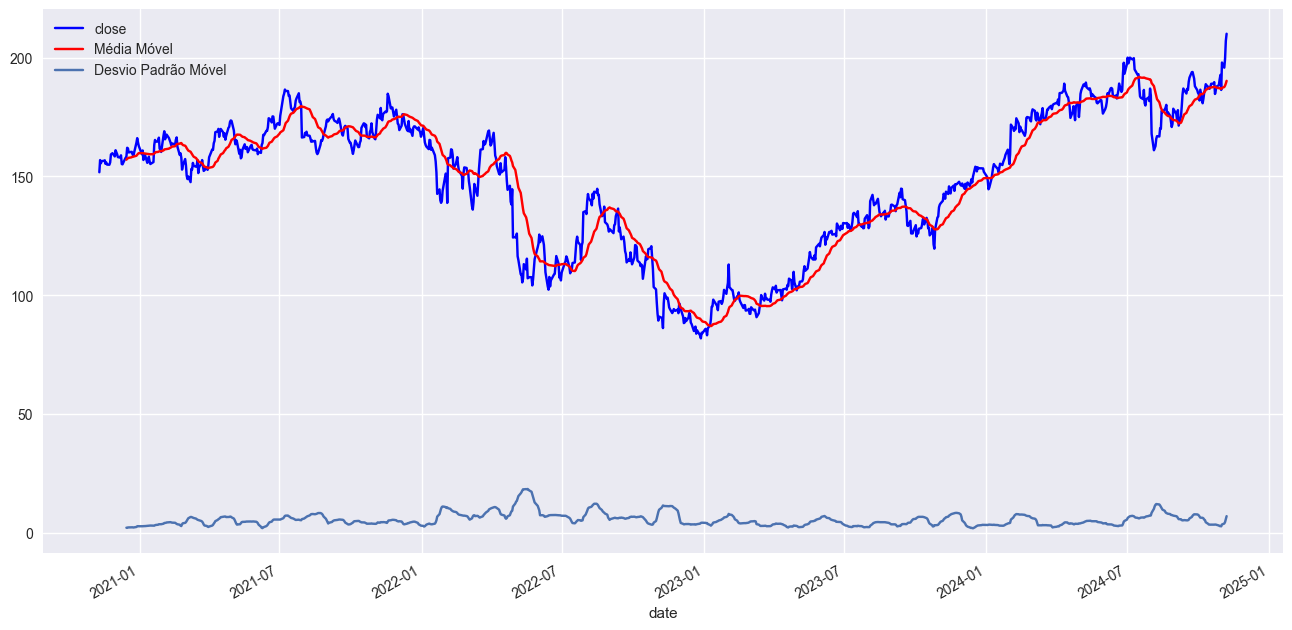

In [9]:
# Plot da média móvel
close = df['close']

# Calcula as estatísticas móveis
ma = close.rolling(window = 25).mean()
std = close.rolling(window = 25).std()

# Plot
plt.figure(figsize = (16,8))
df['close'].plot(color = 'b', label = 'close')
ma.plot(color = 'r', label = 'Média Móvel')
std.plot(label = 'Desvio Padrão Móvel')
plt.legend()

## 5- Dados de Treino e Teste

In [10]:
# Proporção de dados para treino e teste
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
dados_treino, dados_teste = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [11]:
dados_treino.shape

(804, 18)

In [12]:
dados_teste.shape

(201, 18)

### Variável alvo

In [13]:
treino = dados_treino["close"]
teste = dados_teste["close"]

### Variáveis Exógenas

In [14]:
exog_train_data = dados_treino[["VWAP", "RSI", "SMA 300"]]
exog_test_data = dados_teste[["VWAP", "RSI", "SMA 300"]]

## 6- Teste de Estacionaridade

In [15]:
# Função para estar a estacionaridade
def testa_estacionaridade(timeseries):

    # Calcula as estatísticas móveis
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (18,9))
    plt.plot(timeseries, color = 'darkblue', label = 'Original')
    plt.plot(rolmean, color = 'orangered', label = 'Média Móvel')
    plt.plot(rolstd, color = 'grey', label = 'Desvio Padrão Móvel')
    plt.xlabel('Data')
    plt.legend()
    plt.title('Estatísticas Móveis',  fontsize = 15)
    plt.show(block = False)
 
    print('Resultados do Teste Dickey Fuller:')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'Valor-p', 'Número de Lags', 'Número de Observações']
    
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.")
    else:
        print("Evidência fraca contra hipótese nula. Série temporal não é estacionária.")

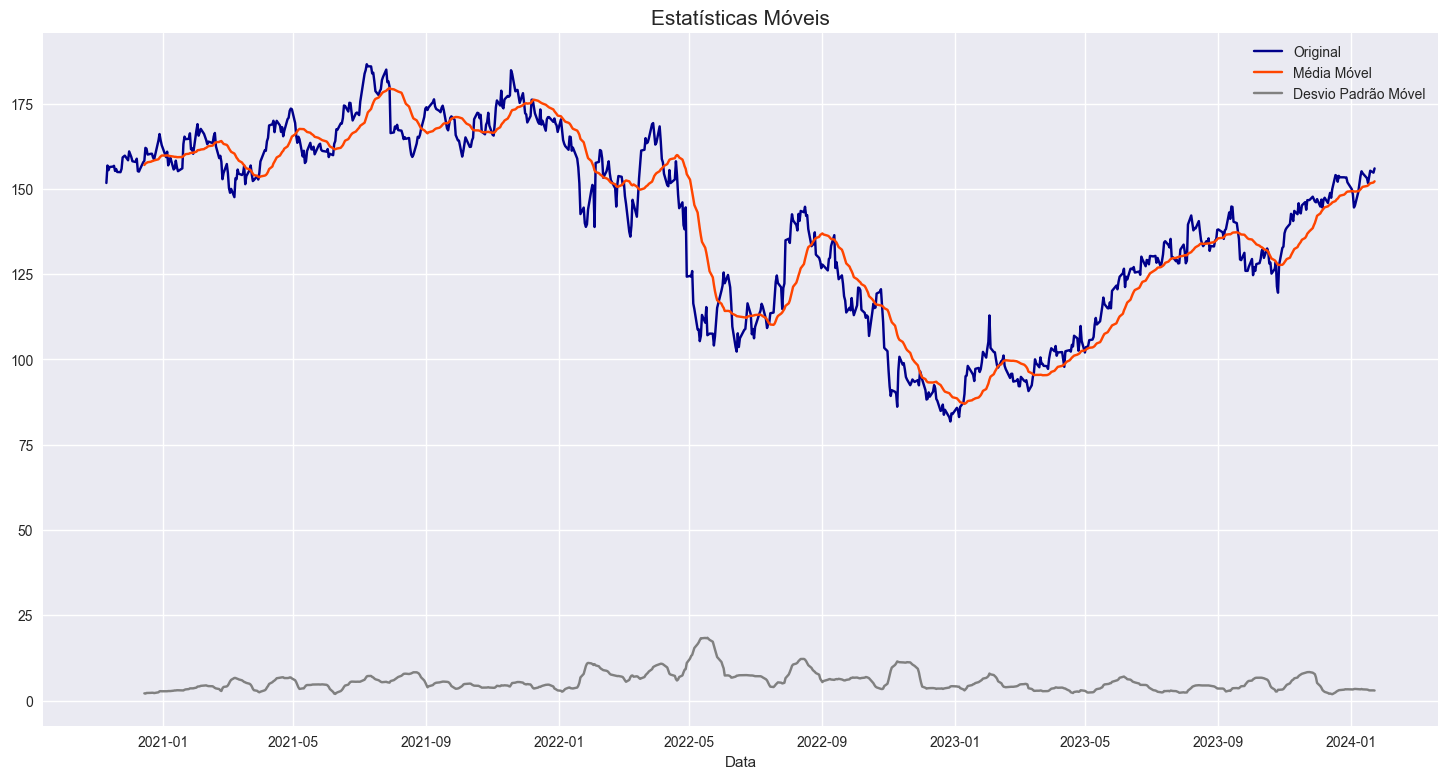

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -1.559351103532378
Valor-p : 0.5039739515684001
Número de Lags : 0
Número de Observações : 803
Evidência fraca contra hipótese nula. Série temporal não é estacionária.


In [16]:
testa_estacionaridade(dados_treino['close'])

## 7- Log & Diferenciação para remover tendência

In [17]:
# Aplica transformação de log
dados_treino_log = np.log(dados_treino['close']) 
dados_teste_log = np.log(dados_teste['close'])

In [18]:
media_movel = dados_treino_log.rolling(25).mean() 

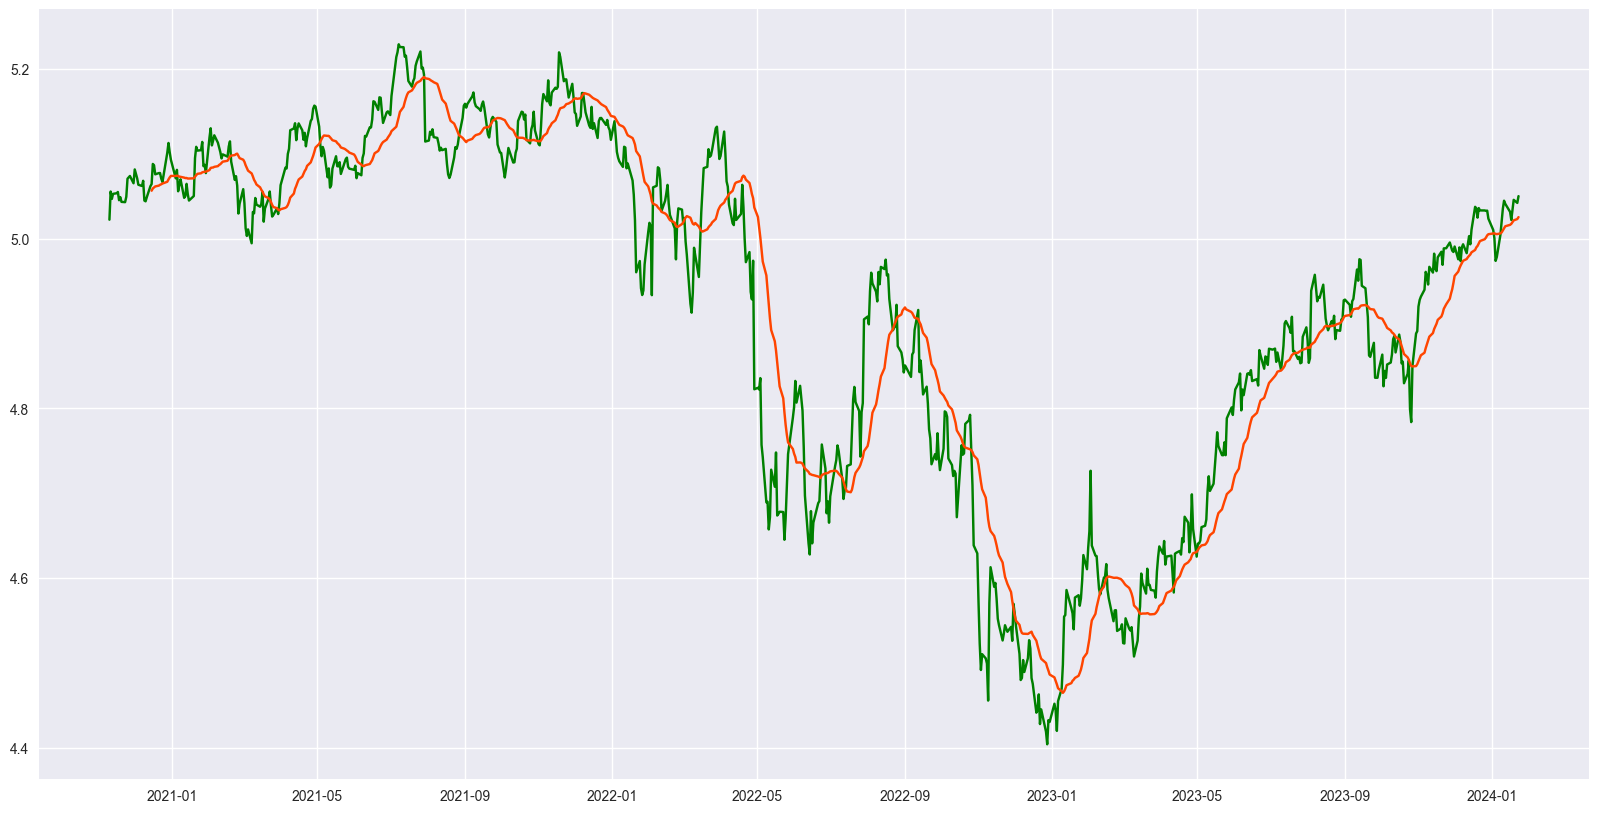

In [19]:
# Plot
plt.figure(figsize = (20,10))
plt.plot(dados_treino_log, color = 'green') 
plt.plot(media_movel, color = 'orangered')

In [20]:
# Drop de valores NA
dados_treino_log.dropna(inplace = True)
dados_teste_log.dropna(inplace = True)

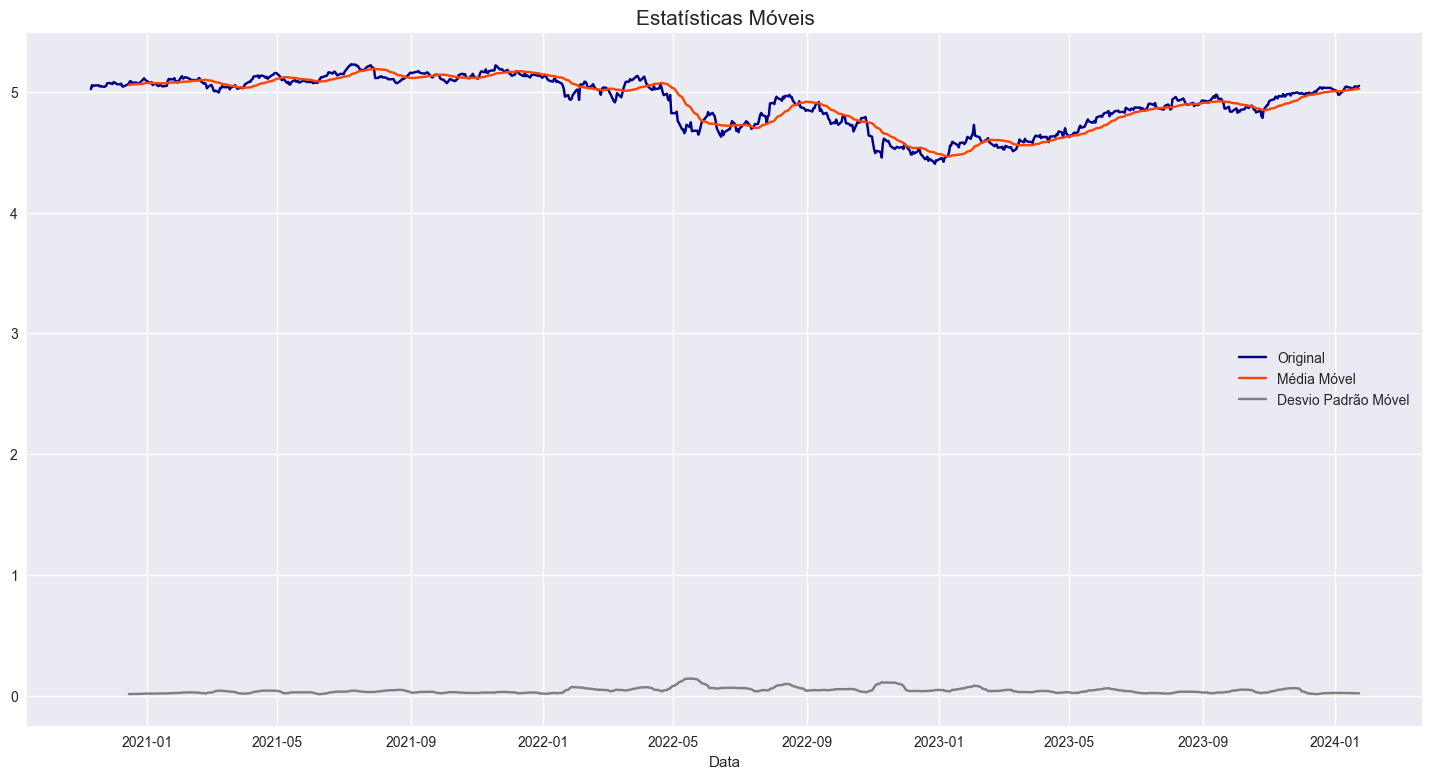

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -1.5554258106998913
Valor-p : 0.5059368245774943
Número de Lags : 0
Número de Observações : 803
Evidência fraca contra hipótese nula. Série temporal não é estacionária.


In [21]:
# Aplica a função
testa_estacionaridade(dados_treino_log)

In [22]:
# Calcula a diferença entre log e media_movel
dados_treino_log_diff = dados_treino_log - media_movel
dados_treino_log_diff.dropna(inplace = True)

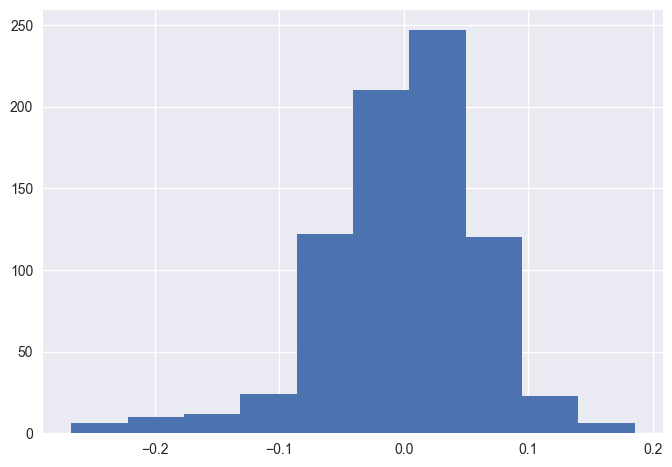

In [23]:
# Histograma
plt.hist(dados_treino_log_diff, histtype = 'stepfilled', rwidth = 0.9)
plt.show()

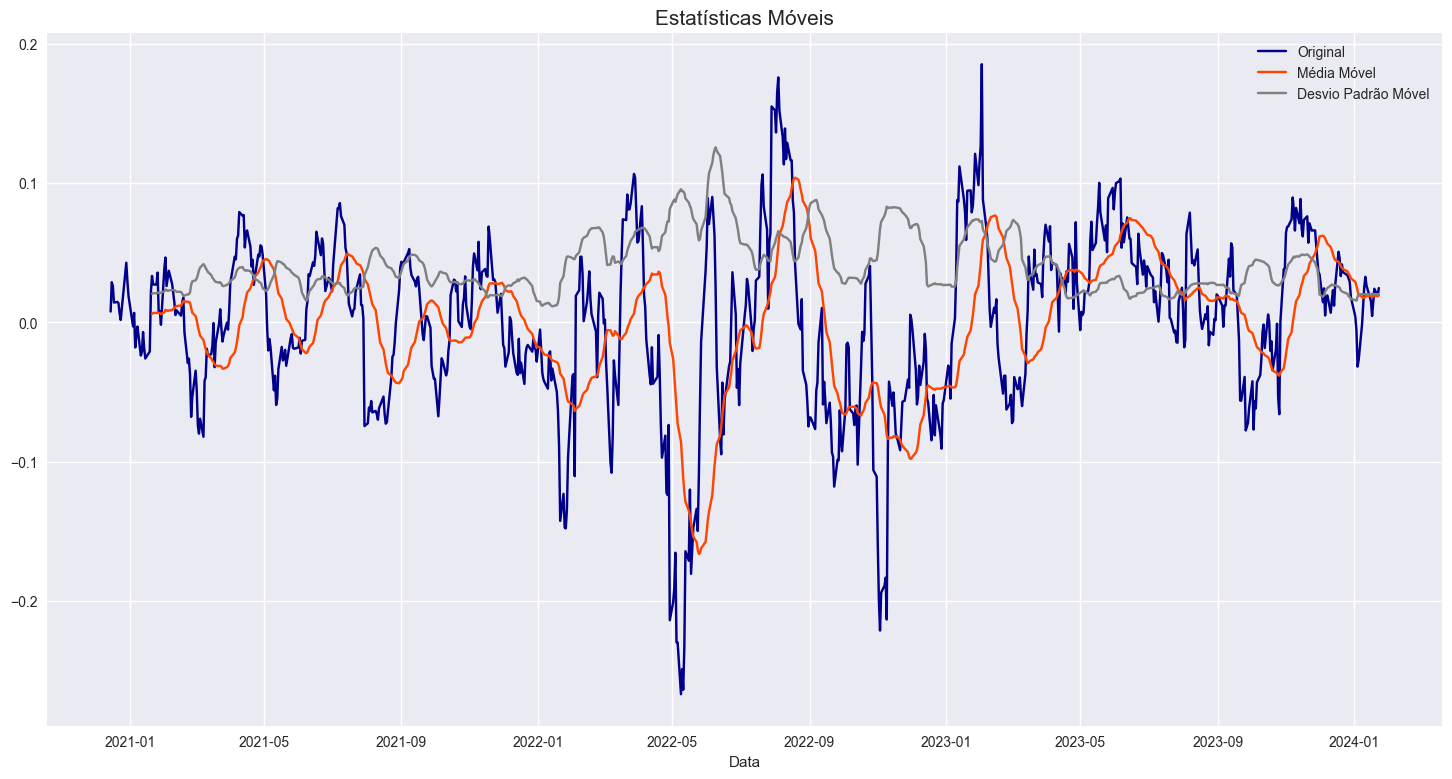

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -5.751431319448015
Valor-p : 5.953947828699728e-07
Número de Lags : 4
Número de Observações : 775
Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.


In [24]:
testa_estacionaridade(dados_treino_log_diff)

## 8- Plots de Autocorrelação

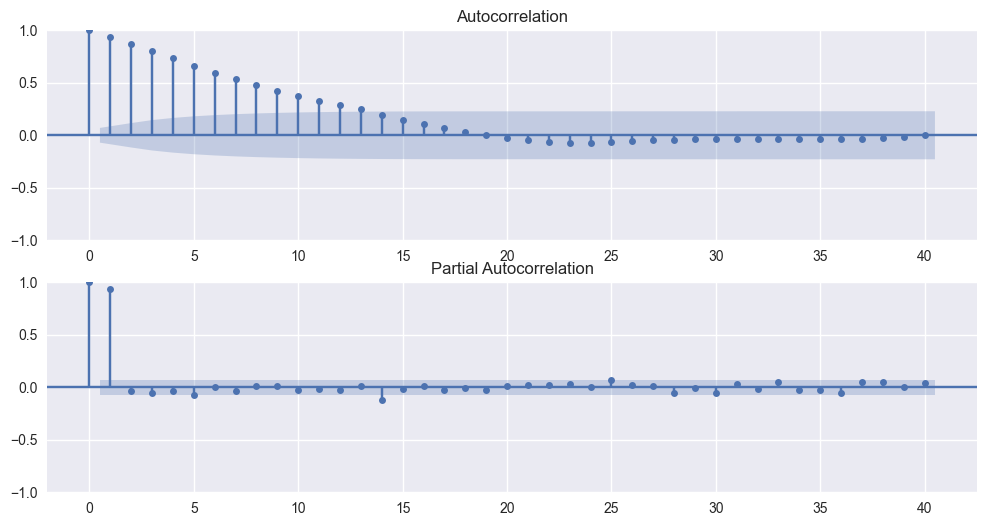

In [25]:
# Plot
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(dados_treino_log_diff, ax = axes[0], lags = 40)
axes[1] = plot_pacf(dados_treino_log_diff, ax = axes[1], lags = 40)

## 9- MODELO ESTATÍSTICO: SARIMAX

In [26]:
# Encontra-se o melhor modelo incluindo as variáveis exógenas nesta etapa
stepwise_model = auto_arima(treino, X=exog_train_data, m=7)
stepwise_model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [27]:
print(stepwise_model.aic())

4105.694663064392


In [28]:
%%time

stepwise_predict = stepwise_model.predict(n_periods = len(teste), X = exog_test_data)

Wall time: 18.2 ms


In [29]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
# Imprime as métricas do teste
MSE_auto_sax_ex = mean_squared_error(teste, stepwise_predict)
print('MSE:', MSE_auto_sax_ex)

RMSE_auto_sax_ex = mean_squared_error(teste, stepwise_predict, squared = False)
print('RMSE:', RMSE_auto_sax_ex)

MAPE_auto_sax_ex = MAPE(teste, stepwise_predict)
print('MAPE:', MAPE_auto_sax_ex)

MSE: 19.351706608068316
RMSE: 4.399057468147957
MAPE: 1.8749987343386052


Text(0, 0.5, 'Valores Reais')

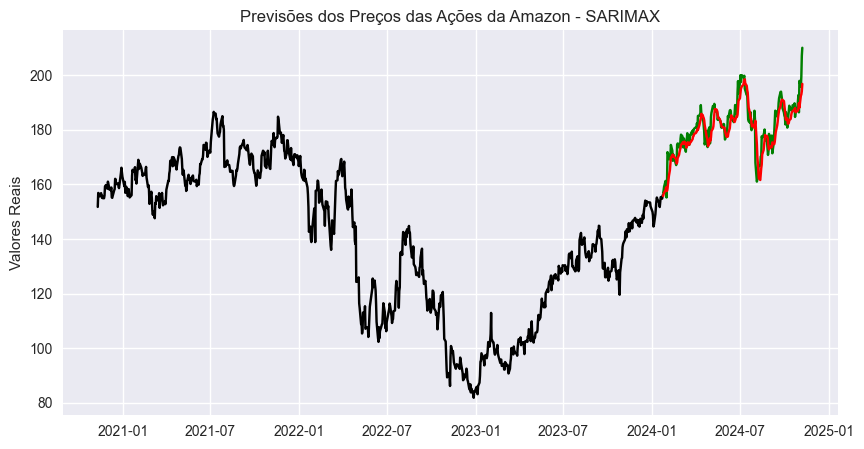

In [31]:
# Plot
previsoes_auto = pd.DataFrame(stepwise_predict.values, index = teste.index, columns = ['Predição'])

plt.figure(figsize = (10,5))
plt.plot(treino, label = 'Dados de Treino', color='black')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(previsoes_auto, label = 'Previsões', color = 'red')
plt.title('Previsões dos Preços das Ações da Amazon - SARIMAX')
plt.ylabel('Valores Reais')

## 9.3- Visualização dos modelos SARIMAX

In [32]:
# Salva o modelo 2
amazon2 = previsoes_auto.rename(columns={'Predição':'AMZN_SARIMAX'})
amazon2a = amazon2["AMZN_SARIMAX"].reset_index()

In [33]:
# Preços reais
teste_empresa = pd.DataFrame(teste.values, index = teste.index, columns = ['AMZN_Preço_Ação'])
teste_empresa = teste_empresa["AMZN_Preço_Ação"].reset_index()

In [34]:
empresa_1 = pd.merge(teste_empresa, amazon2a, on="date")
empresa_1.tail()

,date,AMZN_Preço_Ação,AMZN_SARIMAX
196,2024-11-01,197.929993,188.085791
197,2024-11-04,195.779999,192.432760
198,2024-11-05,199.500000,192.940998
199,2024-11-06,207.089996,194.128700
200,2024-11-07,210.050003,196.816641


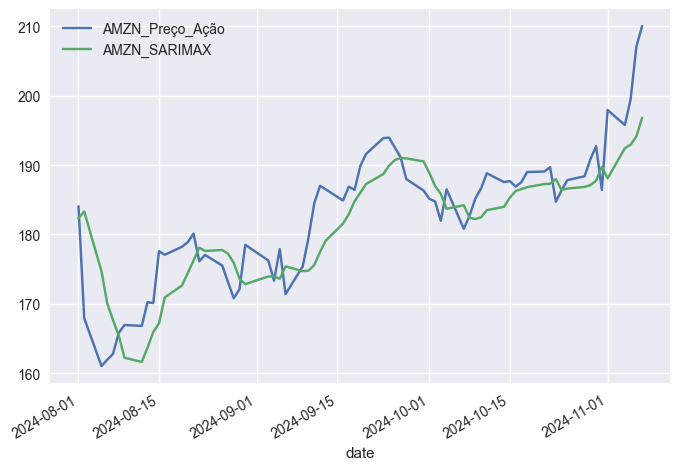

In [35]:
# Filtro por data
amazon_d = (empresa_1["date"] >= '2024-08-01')
amazon_d1 = empresa_1[amazon_d]
#Selecionar colunas na ordem que quero
amazon_d2 = amazon_d1[["date", "AMZN_Preço_Ação", "AMZN_SARIMAX"]]
# Indexar a data
amazon_d3 = amazon_d2.set_index('date')
# Plotar
amazon_d3.plot()
plt.show();

In [36]:
amazon_d2.to_csv('amazon_sarimax.csv')